<a href="https://colab.research.google.com/github/arthursl12/MIR/blob/master/Lab09/lab09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# Esse magic ignora todo o output da célula
# Descomente e rode para usar no colab
!pip install git+https://github.com/flaviovdf/musica.git

# Shazam do GTZAN

**Objetivos**
1. Entender o Shazam!

**Resultado Esperado**
1. Saber criar um índice de constelações
1. Realizar consultas no mesmo

**Caso queira indexar tudo, recomendo o uso da biblioteca sparse, descomente abaixo**

In [2]:
from μsica import μsf
from μsica import μsp

from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd

In [3]:
μsp.init_matplotlib()
plt.ion()

In [4]:
μsf.download('https://homepages.dcc.ufmg.br/~flaviovdf/mir/lab09/archive.zip',
             'archive.zip', False)
μsf.download('https://homepages.dcc.ufmg.br/~flaviovdf/mir/lab09/queryPublic_George.zip',
             'queryPublic_George.zip', False)

archive.zip: 1.21GB [01:54, 11.3MB/s]
queryPublic_George.zip: 723MB [00:35, 21.4MB/s]


In [5]:
μsf.extract('archive.zip', '.')

In [6]:
μsf.extract('queryPublic_George.zip', '.')

In [7]:
! ls

 archive.zip  'mir-2013-GeorgeDataset_snippet(10sec)_1062'   sample_data
 Data	       queryPublic_George.zip


## Introdução

Neste notebook vamos tentar montar um [Shazam](https://shazam.com). Criado em meados de 2003 \[[1](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf)\], o Shazam é um serviço que identifica músicas com base em clipes pequenos. No começo dos anos 2010s, o advento de aplicativos de celulares popularizou o serviço Shazam. Com o passar dos anos, as ideias do Shazam foram copiadas por empresas como a Google a Apple, que incluem variações do serviço de descoberta nos seus sistemas operacionais Android e IOs. Se não me engano, a Apple usa APIs do Shazam, enquanto a Google tem sua versões própria.

![](https://digitalagencynetwork.com/wp-content/uploads/2017/12/confirmed-apple-bought-shazam-app-reasonable-point.jpg)

O funcionamento do Shazam é feito através da técnica de *audio fingerprinting*. Aqui, um índice invertido de atributos musicais é criado. Com tal índice, podemos rapidamente identificar uma música através de um clipe pequeno da mesma. A figura abaixo mostra a ideia de como um serviço seria implementado no mundo real. Aqui, vamos fazer uma versão simples em memória.

![Audio Finger](https://www.audiolabs-erlangen.de/resources/MIR/FMP/data/C7/FMP_C7_F02.png)

## Base de Dados

Para nossa tarefa, vamos fazer uso da base GTZAN. A base GTZAN é composta por 1.000 trechos de música e áudio de meio minuto, classificados individualmente em dez categorias. Por hora, vamos ignorar as categorias e focar apenas nas músicas. Para um melhor entendimento do GTZAN leia a referência \[[2](https://arxiv.org/pdf/1306.1461.pdf)\]. 

### A base de dados que será indexada (GTZAN)

Toda a base GTZAN pode ser encontrada no [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification). Caso necessite, uma versão também pode ser encontrada no drive junto deste notebook.

Abaixo mostramos as pastas e arquivos do GTZAN. Tais músicas vem no formato wav. Sua tarefa será montar um índice de um **subconjunto** de tais músicas. Já explico.

In [8]:
! ls Data/genres_original

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [9]:
! ls Data/genres_original/blues | head

blues.00000.wav
blues.00001.wav
blues.00002.wav
blues.00003.wav
blues.00004.wav
blues.00005.wav
blues.00006.wav
blues.00007.wav
blues.00008.wav
blues.00009.wav


### A base de dados de consulta (MIREX-2020)

Como sua tarefa é montar um Shazam, precisamos de uma base de consultas. Desde 2005, a [Music Information Retrieval Evaluation eXchange (MIREX 2020)](https://www.music-ir.org/mirex) organia competições no tema de recuperação de informação musical. Já fazem alguns anos, desde 2013, onde anualmente uma das competições do MIREX é no tema de *audio fingerprinting* (nossa tarefa). O link ao lado contém a descrição da tarefa [Audio Fingerprinting MIREX 2020](https://www.music-ir.org/mirex/wiki/2020:Audio_Fingerprinting).

Para simular o uso do Shazam, junto com tal competição, uma base de dados de consultas é fornecida. Tal base foi gravada em telefones celulares em diferentes ambientes. Para entender o formato de tal base, segue uma lista dos arquivos.

In [10]:
! ls -l mir-2013-GeorgeDataset_snippet\(10sec\)_1062

total 924392
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00000-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00000-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00000-snippet-10-20.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00003-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00003-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00003-snippet-10-20.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00004-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00004-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00005-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00005-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00005-snippet-10-20.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00009-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 blues.00009-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 19 11:30 

Observe como cada arquivo corresponde a uma música do GTZAN. Além do mais, três clipes de 10 segundos são fornecidos por música. Por exemplos, a música `blues.00000.wav`do GTZAN tem como respostas os clipes: `blues.00000-snippet-10-0.wav`, `blues.00000-snippet-10-10.wav`, `blues.00000-snippet-10-20.wav`.

## Sua Tarefa

Sabendo das bases acima, sua tarefa será em indexar e mensurar a Precision@10 (fração de acertos na primeira posição retornada) das músicas acima. **Por questões de memória limitada, você pode indexar apenas as músicas de consulta, não precisa indexar todo GTZAN. Faça tudo na memória principal mesmo**.

Para realizar sua tarefa crie mapas de constetalação das músicas e da consulta.

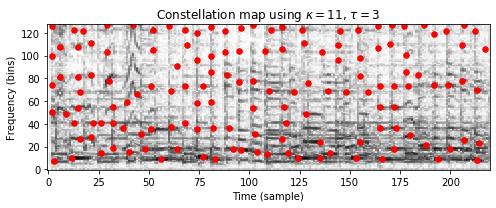

### *Importante*: Fourier no GTZAN

No GTZAN, cada música é gravada a uma taxa de amostragem de 22,05 kHz e arquivos de áudio mono de 16 bits no formato `.wav`. *Como toda música tem a mesma taxa de amostragem, os índices discretos da transformada de Fourier são os mesmos para todas as músicas. ELAS JÁ VEM BINARIZADAS NO EIXO-Y do mapa de constelação*.

## Carregando os Espectrogramas

O código abaixo carrega os espectrogramas. Coloquei também um função que plota os mesmos.

In [11]:
import warnings
warnings.filterwarnings('ignore')

def plot_spec(stft, sr, constelation=None):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
                                   y_axis='log',
                                   x_axis='time',
                                   hop_length=sr,
                                   ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    if constelation is not None and constelation.any():
        x, y = np.where(constelation.T)
        ax.scatter(x, y, s=100, alpha=0.6, edgecolor='k')
    fig.show()

**Observe como passo o `hop_length=sr` no stft**. Como estou com uma música com taxa SR por segundo, tiro a média a cada SR frames. Isso deixa meu espectrograma em SEGUNDOS. Algumas musicas passam um pouco de 30 segundos, portanto pego os trinta na marra.

In [12]:
def my_stft(wave, sr):
    stft_complex = librosa.stft(wave, hop_length=sr) # deve ter approx 30 secs
    stft = np.abs(stft_complex) # tira a norma do real e imag
    return stft[:, :30] # força 30 secs

(1025, 30)

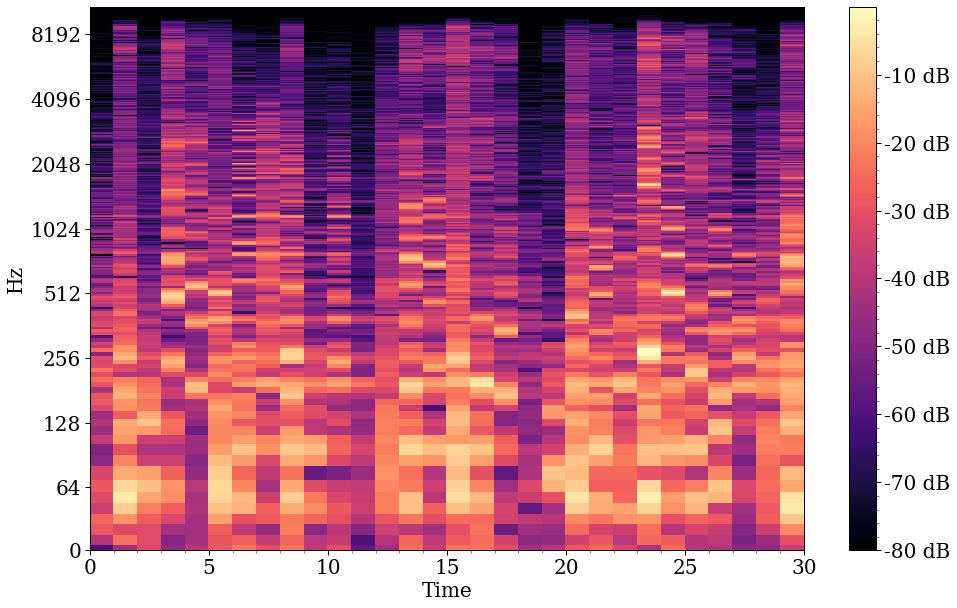

In [13]:
wave, sr = librosa.load('Data/genres_original/blues/blues.00001.wav',
                        mono=True)
stft = my_stft(wave, sr)
plot_spec(stft, sr)
stft.shape

### Mapa de Constelação

O mapa pode ser implementado com a chamada: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html. O `mode='constant'` faz um preenchimento nas bordas para garantir que tudo funcione. O `size` diz o tamanho do filtro que vamos usar.

In [14]:
from scipy import ndimage

def constellation_map(stft, kappa=7, tau=7, thresh=0.01):
    result = ndimage.maximum_filter(stft, size=[2*kappa+1, 2*tau+1],
                                    mode='constant')
    C = np.logical_and(stft == result, result > thresh)
    return C

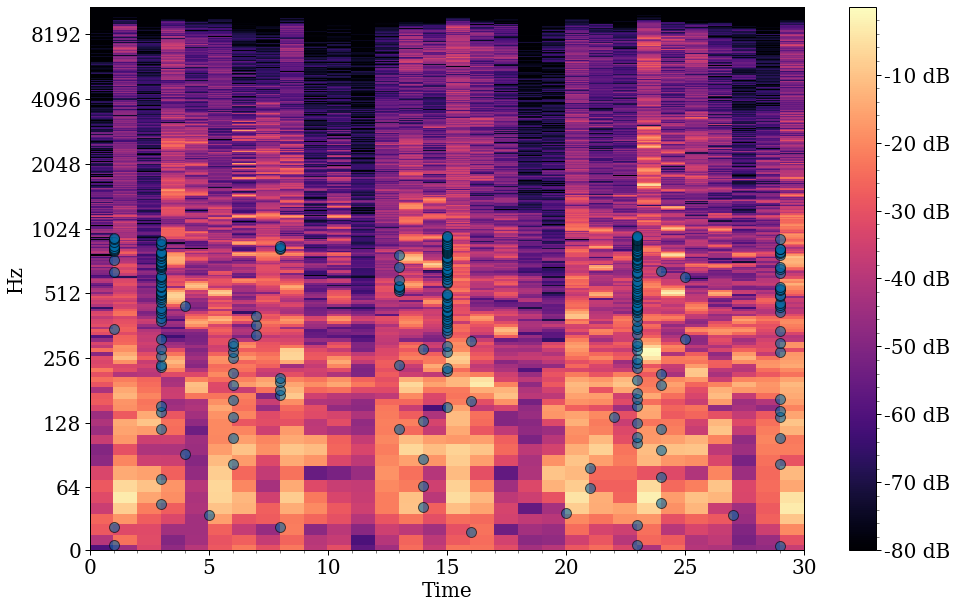

In [15]:
constelation = constellation_map(stft, kappa=5, tau=5)
plot_spec(stft, sr, constelation)

## Índice

Observe como cada consulta precisa ser comparada com todas as seções (tendo a mesma duração da consulta) de todas as músicas contidas no base de dados. Tal estratégia de busca exaustiva, cujo tempo de execução depende linearmente do número e do tamanho da base de dados, não é viável. Portanto você deve implementar um índice como visto em sala de aula. A função `match_query_gtzan` lhe ajuda a carregar apenas os arquivos que existem na base de consultas.

In [16]:
import glob
import os

def match_query_gtzan():
    # Os arquivos do 'classical.0074' estão com letra maiúscula, 
    # devem ser corrigidos
    to_be_renamed = [
        'mir-2013-GeorgeDataset_snippet(10sec)_1062/Classical.00074-snippet-10-0.wav',
        'mir-2013-GeorgeDataset_snippet(10sec)_1062/Classical.00074-snippet-10-10.wav',
        'mir-2013-GeorgeDataset_snippet(10sec)_1062/Classical.00074-snippet-10-20.wav'
    ]
    for file in to_be_renamed:
        if (os.path.exists(file)):
            new_name = file.replace('Classical','classical')
            os.rename(file, new_name)

    # Código fornecido
    rv = {}
    path = os.path.join('mir-2013-GeorgeDataset_snippet(10sec)_1062', '*.wav')
    for wav_fpath in glob.glob(path):
        file_name = os.path.basename(wav_fpath)
        file_name_gztan = '{}{}'.format(file_name.split('-')[0], '.wav')
        genre = file_name_gztan.split('.')[0]
        rv[wav_fpath] = os.path.join('Data', 'genres_original', genre,
                                     file_name_gztan)
    return rv
matches = match_query_gtzan()
print(list(matches.items())[:10])

[('mir-2013-GeorgeDataset_snippet(10sec)_1062/pop.00011-snippet-10-20.wav', 'Data/genres_original/pop/pop.00011.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/disco.00064-snippet-10-20.wav', 'Data/genres_original/disco/disco.00064.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/reggae.00050-snippet-10-0.wav', 'Data/genres_original/reggae/reggae.00050.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/rock.00055-snippet-10-10.wav', 'Data/genres_original/rock/rock.00055.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/country.00009-snippet-10-20.wav', 'Data/genres_original/country/country.00009.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/blues.00085-snippet-10-10.wav', 'Data/genres_original/blues/blues.00085.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/country.00044-snippet-10-20.wav', 'Data/genres_original/country/country.00044.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/blues.00020-snippet-10-10.wav', 'Data/genres_original/blues/blues.00020.wav'), ('

## Problemas

1. Implemente o índice acima. É possível implementar o mesmo na memória. Use estruturas python ou uma matriz esparsa 3d (um tensor). Veja a descrição do lab. Da para fazer sem o sparse, mas não deve funcionar na base toda.
1. Realize as consultas e mensure o seu valor de precision@10
1. Qual o efeito do kappa e do tau no seu resultado?
1. Mude seu código para funciona na base toda (*extra*)

### 1) Implementação do Índice



Seguindo as sugestões vistas na aula, conceber a função que cria o índice foi bem direto. Mas para facilitar e acelerar outras execuções com parâmetros diferentes, vamos separar as funções de carregamento e entregar apenas os STFTs para as funções.

In [17]:
def load_stft(audio_list):
    """
    Carrega e extrai os STFTs dos áudios originais via librosa.load e a função
    fornecida 'my_stft'.

    Parâmetros:
        audio_list: lista de caminhos para os arquivos de áudio para serem 
                    processados via STFT
    Retorno:
        stft_dict: dicionário que mapeia o nome do arquivo (caminho) para seu
                   respectivo STFT
    """
    stft_dict = {}
    total = len(audio_list)
    i = 0
    for audio in audio_list:
        if (audio == 'Data/genres_original/jazz/jazz.00054.wav'):
            # Arquivo possivelmente corrompido, ignorar
            continue
        wave, sr = librosa.load(audio, mono=True)
        stft = my_stft(wave, sr)
        stft_dict[audio] = stft
        i += 1
        print(f'\r{(i*100/total):.1f}%', end='')
    print(f'\r{100}%')
    return stft_dict

In [18]:
# Carregar as músicas originais
# set para elimitar repetidos
stft_dict_originals = load_stft(set(matches.values()))

100%


In [19]:
# Carregar as querys
# Obs.: esse carregamento demora alguns minutos (~8min)
stft_dict_querys = load_stft((list(matches.keys())))

100%


Com isso, podemos montar a lista invertida para a base que usaremos.

In [20]:
from collections import defaultdict

def index(colecao_de_stfts, kappa=5, tau=5):
    """
    Cria a lista invertida de frequências (ou níveis de frequência) para tempos
    nas mais diversas músicas (documentos)

    Parâmetros:
        colecao_de_stfts: dicionário de STFTs dos arquivos originais, com as 
                          chaves sendo os caminhos
        kappa: valor de vizinhança de frequência (default=5)
        tau: valor de vizinhança do tempo (default=5)
    Retorno:
        index_dict: lista invertida de frequências 
    """
    index_dict = defaultdict(lambda: defaultdict(list))

    for audio, stft in colecao_de_stfts.items():
        constelation = constellation_map(stft, kappa=kappa, tau=tau)
        for freq, time in zip(*np.where(constelation)):
            index_dict[freq][time].append(audio)
    return index_dict

In [21]:
index_dict = index(stft_dict_originals, kappa=5, tau=5)

Nessa lista invertida, pode-se interpretar os índices usados para consulta da seguinte forma. Por exemplo, suponhamos uma consulta:

```
index_dict[42][9]
```
Ela retorna as músicas cujo mapa de constelação possui a frequência 42 no tempo 9.



In [22]:
index_dict[42][9]

['Data/genres_original/jazz/jazz.00060.wav',
 'Data/genres_original/metal/metal.00035.wav',
 'Data/genres_original/rock/rock.00015.wav',
 'Data/genres_original/reggae/reggae.00019.wav']

### 2) Consultas



Com a lista invertida, podemos usá-la para fazer uma consulta (*query*) de um trecho de música e descobrir qual é. Mas primeiro, precisamos definir duas funções auxiliares para realizar o casamento dos pares (frequência, tempo).

In [23]:
def match(peaks, inverted_lists, docs):
    """
    Realiza o casamento de um mapa de constelação de uma música query com os 
    mapas das várias músicas na base de dados, via lista invertida. O algoritmo
    parte das frequências presentes efetivamente na música consultada para 
    evitar computações desnecessárias.

    Parâmetros:
        peaks: mapa de constelação da música query
        inverted_lists: lista invertida para frequências e tempos dos vários 
                        documentos (músicas) da base de músicas
        docs: lista de nomes dos arquivos de áudio (caminhos) das músicas 
              originais caminhos para os arquivos de áudio
    Retorno:
        indicators_dict: dicionário de tabelas de matches, as chaves são os 
                         caminhos das várias músicas com alguma similaridade 
                         (não necessariamente todas)
        map_docs: mapa de nome de arquivo de áudio original para índice do 
                  dicionário de indicadores
    """
    # "Dicionário" de tabelas de matches para várias músicas.
    # Cada tabela é semelhante à figura 7.6 do livro (seção 7.1.3)
    indicators_dict = np.zeros((len(docs),len(peaks),61), dtype=np.int8)

    # Mapas para indexação no array de indicators
    # map_peaks: pares que identificam os picos -> int
    # map_docs: nomes das músicas originais (documentos) -> int
    map_peaks = {k: v for v, k in enumerate(peaks)}
    map_docs = {k: v for v, k in enumerate(docs)}

    # Iterando por todas as frequências relevantes da query
    for freq, tempo in peaks:
        for t_idx in inverted_lists[freq]:
            # Música também tem esse pico nessa mesma frequência e tempo
            # Pode ser mais de uma música, por isso o loop
            for doc in inverted_lists[freq][t_idx]:
                # Adiciona o match encontrado à tabela dessa música
                idx = map_peaks.get((freq,tempo))
                doc_idx = map_docs.get(doc)
                diff = t_idx - tempo    
                indicators_dict[doc_idx,idx, diff] += 1

    return indicators_dict, map_docs

Agora já é possível montar a função que processa uma query completa.

In [24]:
def query(snippet_stft, inverted_lists, docs, kappa, tau, precision_at=10):
    """
    Executa uma consulta de uma música numa base via lista invertida.

    Parâmetros:
        snippet: caminho do arquivo da música a ser consultada
        inverted_lists: lista invertida que representa a base
        kappa: valor de vizinhança de frequência 
               (usado no mapa de constelação do snippet)
        tau: valor de vizinhança do tempo 
             (usado no mapa de constelação do snippet)
        precision_at: nível de precisão, i.e., quantos elementos se deseja na 
                      lista de música similares (default=10)
    Retorno:
        final_sorted: lista ordenada com 'precision_at' músicas similares,
                      ordenadas da mais similar para a menos. A lista é composta
                      de triplas do tipo (caminho, grau de similaridade, 
                      índice de casamento de tempo do snippet)
    """
    # Cria o mapa de constelação do audio de consulta
    constelation = constellation_map(snippet_stft, kappa=kappa, tau=kappa)
    
    # Lista de coordenadas onde há picos no mapa de constelação
    # (x,y): (frequência, tempo)
    peaks = list(zip(*np.where(constelation)))

    # Matching com as músicas
    indicators_dict, map_docs = match(peaks, inverted_lists, docs=docs)
    inv_map_docs = {v: k for k, v in map_docs.items()}

    # Compilação dos Resultados
    results = []
    for i in range(indicators_dict.shape[0]):
        if (i not in inv_map_docs):
            continue
        doc_indicator = indicators_dict[i]
        sumarized = doc_indicator.sum(axis=0)
        argmax = np.argmax(sumarized)
        max = sumarized.max()
        result = (inv_map_docs[i], max, argmax)
        results.append(result)

    # Ordenar e retornar apenas as 'r' mais similares
    final_sorted = sorted(results, key=lambda tup: tup[1], reverse=True)
    return final_sorted[:precision_at]

In [25]:
snippet = 'mir-2013-GeorgeDataset_snippet(10sec)_1062/country.00064-snippet-10-0.wav'
snippet_stft = stft_dict_querys[snippet]
kappa=5
tau=5
inv_list = index(stft_dict_originals, kappa=kappa, tau=tau)
result = query(snippet_stft, inv_list, docs=set(matches.values()), kappa=kappa, tau=tau)
result

[('Data/genres_original/classical/classical.00059.wav', 7, 59),
 ('Data/genres_original/metal/metal.00039.wav', 6, 19),
 ('Data/genres_original/jazz/jazz.00069.wav', 6, 58),
 ('Data/genres_original/reggae/reggae.00069.wav', 6, 0),
 ('Data/genres_original/pop/pop.00079.wav', 5, 58),
 ('Data/genres_original/pop/pop.00019.wav', 5, 10),
 ('Data/genres_original/pop/pop.00070.wav', 5, 14),
 ('Data/genres_original/metal/metal.00034.wav', 5, 22),
 ('Data/genres_original/country/country.00024.wav', 5, 10),
 ('Data/genres_original/metal/metal.00012.wav', 5, 14)]

#### 2.1) Precisão


Usaremos uma definição diferente da do livro para precisão, como orientado em aula. Sendo a precisão $r$ uma lista das $r$ músicas mais similares segundo o algoritmo, verificamos em qual posição $n$ está a música correta e retornamos $\frac{r-n}{r}$.

Assim, por exemplo, dentre 10 retornadas, se a música certa foi considerada a mais similar (índice $n=0$), temos uma precisão de 1 (máxima). Se foi a 8ª retornada (índice $n=7$), então temos uma precisão de 0.7. Se foi a 10ª, 0.1. Se não está entre as 10 retornadas, precisão de 0.



In [26]:
def precision(snippet_name, query_result, map_names, r=10):
    """
    Calcula a precisão para um dado snippet de música e o resultado de sua query

    Parâmetros:
        snippet_name: nome (e caminho) do arquivo de áudio do snippet
        query_result: lista de triplas de resultado da query (ordenadas)
        map_names: mapa de nomes de snippets para nomes das músicas originais
                  (fornecido)
        r: nível da precisão (verifica se, nos 'r' primeiros resultados temos 
           a música certa)
    Retorno:
        p: valor da precisão
    """
    assert(len(query_result) >= r)
    # Pega apenas os nomes dos 'r' arquivos mais similares similares encontrados
    useful_results = list(list(zip(*query_result[:r]))[0])
    correct = map_names[snippet]        # Nome do relevante (música correta)

    if (correct in useful_results):
        n = useful_results.index(correct)
        return (r-n)/r
    else:
        return 0

Portanto, a precisão do exemplo que é feito até o momento é:

In [27]:
precision(snippet, result, matches)

0

#### 2.2) Precisão no gênero

Podemos extender o conceito de precisão para também o gênero musical. Isso nos permitirá verificar se há alguma correlação entre esse parâmetro e a capacidade de identificação de nosso algoritmo.

A definição é análoga à precisão conceituada anteriormente, mas é menos específica, visto que considera um acerto se o gênero musical correto estiver presente nos gêneros das $r$ músicas mais similares. 

In [28]:
def extract_genre(path):
    """
    Dado um caminho do tipo: 'Data/genres_original/<gênero>/*.wav', retorna o 
    gênero correspondente.

    Parâmetros:
        path: caminho conforme especificado
    Retorno:
        genre: gênero correspondente
    """
    genre = path.split('/')[2]
    return genre

In [29]:
def precision_genre(snippet_name, query_result, map_names, r=10):
    """
    Calcula a precisão de gênero musical para um dado snippet de música e o 
    resultado de sua query. O conceito é similar à precisão convencional usada
    no trabalho, mas aqui só se considera o gênero musical correto.

    Parâmetros:
        snippet_name: nome (e caminho) do arquivo de áudio do snippet
        query_result: lista de triplas de resultado da query (ordenadas)
        map_names: mapa de nomes de snippets para nomes das músicas originais
                  (fornecido)
        r: nível da precisão (verifica se, nos 'r' primeiros resultados temos 
           a música certa)
    Retorno:
        p: valor da precisão (de gênero musical)
    """
    assert(len(query_result) >= r)
    # Pega apenas os nomes dos 'r' arquivos mais similares similares encontrados
    # e extrai o gênero musical de cada um
    useful_results = list(list(zip(*query_result[:r]))[0])
    useful_genres = [extract_genre(x) for x in useful_results]
    
    # Nome do relevante (música correta) e extração do seu gênero musical
    correct = map_names[snippet]        
    correct_genre = extract_genre(correct)

    if (correct_genre in useful_genres):
        n = useful_genres.index(correct_genre)
        return (r-n)/r
    else:
        return 0

In [30]:
precision_genre(snippet, result, matches)

0.2

#### 2.3) Todas as músicas

Finalmente, vamos verificar o desempenho do algoritmo com todas as músicas pedidas e carregadas.

In [31]:
def run_all_queries(stft_dict_querys, stft_dict_originals, kappa, tau, r, matches):
    """
    Executa queries para todas as músicas do dicionário de entrada, a partir de 
    seus respectivos STFTs já calculados.

    Parâmetros:
        stft_dict_querys: dicionário de STFTs das músicas snippets
        stft_dict_originals: dicionário de STFTs das músicas originais
        kappa: valor de vizinhança de frequência 
               (usado nos mapas de constelação)
        tau: valor de vizinhança do tempo (usado nos mapas de constelação)
        r: nível de precisão, i.e., quantos elementos se deseja na 
           lista de música similares obtida pelo algoritmo
        matches:
    Retorno:
        results: lista de triplas (nome_snippet, precisão, precisão gênero)

    """
    # Lista invertida
    inv_list = index(stft_dict_originals, kappa=kappa, tau=tau)
    
    # Para todas os snippets com STFT
    results = []
    docs = set(matches.values())
    total = len(stft_dict_querys.items())
    i = 0
    for snippet, stft in stft_dict_querys.items():
        # Consulta via lista invertida e obtém as precisões
        result = query(stft, inv_list, kappa=kappa, tau=tau, docs=docs)
        p = precision(snippet, result, matches, r=r)
        p_g = precision_genre(snippet, result, matches, r=r)
        triple = (snippet, p, p_g)
        results.append(triple)

        # Porcentagem, para controle e acompanhamento
        i += 1
        print(f'\r{(i*100/total):.1f}%', end='')
    print(f'\r{100}%')

    return results

In [32]:
results = run_all_queries(stft_dict_querys, stft_dict_originals, kappa=5, tau=30, r=10, matches=matches)

100%


In [33]:
def global_precision(results):
    """
    Computa a precisão média do algoritmo, considerando todas as músicas query

    Parâmetros:
        results: lista de triplas saída do procedimento 'run_all_queries'
    Retorno:
        accuracy_prec: média da precisão de cada música
        accuracy_prec_g: média da precisão do gêneros de cada música 
    """
    # Desempacota os resultados
    names, prec, prec_g = list(zip(*results))
    
    # Acurácia média
    accuracy_prec = np.average(prec)
    accuracy_prec_g = np.average(prec_g)

    return accuracy_prec, accuracy_prec_g

In [34]:
global_precision(results)

(0.0016007532956685499, 0.48455743879472696)

A precisão não parece boa com esses parâmetros $\kappa=5$ e $\tau=30$. Por isso, vamos fazer uma pequena investigação para escolher valores mais adequados para nossa tarefa, de forma semelhante a um grid search em ML, no item seguinte.

### 3) Efeito de $\kappa$ e $\tau$

Os parâmetros $\kappa$ e $\tau$ afetam a granularidade do mapa de constelações, ou seja, definem o tamanho da vizinhança considerada ao se decidir os picos do espectrograma. Um atua no tempo ($\tau$), o outro na frequência ($\kappa$).

Em linhas gerais, quanto maior esse parâmetro, maior é a área da vizinhança e menos picos temos. Se forem escolhidos valores muito pequenos, perderemos capacidade de generalização e robustez do algoritmo, visto que haverão muitos picos e a "tolerância" advinda dessa noção de vizinhança e picos será diminuída. Assim, perde-se robustez perante variações no espectrograma advindas de ruídos, diferentes qualidades de gravação e outros fatores. 

Como as amostras usadas para as queries têm apenas $10s$, um parâmetro $\tau$ muito grande reduzirá bastante a quantidade de pontos nessa dimensão, o que pode dificultar a identificação das músicas. Assim, espera-se um valor menor para o $\tau$. Para o $\kappa$ a ideia é o contrário: há bastantes faixas de frequência, logo um parâmetro maior será útil para amenizar eventuais variações e facilitar o reconhecimento.

É evidente que, com maiores parâmetros e, por isso, menos picos, o tempo de execução será reduzido, já que a lista invertida ficará menor.

In [35]:
import itertools  

list_tau = [1, 2, 3, 4, 5]
list_kappa = [26, 27, 28, 29]
product = list(itertools.product(list_tau, list_kappa))

In [36]:
grid_search = {}
for tau,kappa in product:
    results = run_all_queries(stft_dict_querys, stft_dict_originals, 
                              kappa=kappa, tau=tau, r=10, matches=matches)
    ac_prec, ac_g = global_precision(results)
    grid_search[(tau,kappa)] = (ac_prec, ac_g)
    # print(f'tau={tau}, kappa={kappa}: {ac_prec:.3f}, {ac_g:.3f}')

100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%
100%


In [37]:
sorted(grid_search.items(), key=lambda x: x[1],reverse=True)[:10]

[((4, 28), (0.015630885122410548, 0.3321092278719398)),
 ((3, 28), (0.014500941619585686, 0.38163841807909604)),
 ((3, 29), (0.014124293785310734, 0.3643126177024482)),
 ((4, 27), (0.014124293785310734, 0.34548022598870054)),
 ((1, 26), (0.013653483992467044, 0.47391713747645947)),
 ((4, 29), (0.013559322033898306, 0.3153483992467043)),
 ((4, 26), (0.012994350282485877, 0.34990583804143127)),
 ((1, 27), (0.012146892655367234, 0.47674199623352165)),
 ((3, 27), (0.01214689265536723, 0.3937853107344633)),
 ((5, 26), (0.01214689265536723, 0.3229755178907721))]

Pode-se notar que valores de $\tau=4$ e $\kappa=28$ têm os melhores resultados no quesito precisão da música.

#### 3.1) Análise dos Resultados

Vamos analisar alguns exemplos de sucesso e falha do algoritmo.

In [39]:
results = run_all_queries(stft_dict_querys, stft_dict_originals, 
                          kappa=4, tau=28, r=10, matches=matches)

100%


In [41]:
# Desempacota os resultados
names, prec, prec_g = list(zip(*results))

Em primeiro, uma música que ele acertou o nome (0.6) e consequentemente o seu gênero.

In [42]:
n, p, p_g = results[np.argmax(prec)]
print((n,p,p_g))
n_original = matches[n]

wav, sr = librosa.load(n);
ipd.display(ipd.Audio(wav, rate=sr))
wav, sr = librosa.load(n_original);
ipd.display(ipd.Audio(wav, rate=sr))

('mir-2013-GeorgeDataset_snippet(10sec)_1062/country.00064-snippet-10-10.wav', 0.6, 0.6)


Em seguida, vemos uma que ele não conseguiu acertar o nome da música, mas acertou o gênero em cheio (1.0).

In [43]:
n, p, p_g = results[np.argmax(prec_g)]
print((n,p,p_g))
n_original = matches[n]

wav, sr = librosa.load(n);
ipd.display(ipd.Audio(wav, rate=sr))
wav, sr = librosa.load(n_original);
ipd.display(ipd.Audio(wav, rate=sr))

('mir-2013-GeorgeDataset_snippet(10sec)_1062/country.00044-snippet-10-20.wav', 0, 1.0)


Finalmente, um exemplo em que o algoritmo não conseguiu encontrar nem o gênero nem a música.

In [44]:
n, p, p_g = results[np.argmin(prec)]
print((n,p,p_g))
n_original = matches[n]

wav, sr = librosa.load(n);
ipd.display(ipd.Audio(wav, rate=sr))
wav, sr = librosa.load(n_original);
ipd.display(ipd.Audio(wav, rate=sr))

('mir-2013-GeorgeDataset_snippet(10sec)_1062/pop.00011-snippet-10-20.wav', 0, 0)


### 4) Expansão para toda a base

Vamos indexar toda a base presente em 'Data/genres_original'. Eram cerca de 370 músicas na tarefa anterior, agora são 1000.

In [45]:
# Carrega toda a base
all_songs = []
for root, dirs, files in os.walk('Data/genres_original'):
    for name in files:
        all_songs.append(os.path.join(root, name))
        # print(os.path.join(root, name))
print(len(all_songs))
all_songs[:10]

1000


['Data/genres_original/jazz/jazz.00002.wav',
 'Data/genres_original/jazz/jazz.00013.wav',
 'Data/genres_original/jazz/jazz.00066.wav',
 'Data/genres_original/jazz/jazz.00049.wav',
 'Data/genres_original/jazz/jazz.00041.wav',
 'Data/genres_original/jazz/jazz.00046.wav',
 'Data/genres_original/jazz/jazz.00026.wav',
 'Data/genres_original/jazz/jazz.00036.wav',
 'Data/genres_original/jazz/jazz.00068.wav',
 'Data/genres_original/jazz/jazz.00025.wav']

In [46]:
# Carregar as músicas originais
stft_dict_originals = load_stft(all_songs)

100%


In [47]:
results = run_all_queries(stft_dict_querys, stft_dict_originals, 
                          kappa=4, tau=28, r=10, matches=matches)

100%


In [48]:
global_precision(results)

(0.0, 0.5260828625235405)

O resultado é pior do que o com menos músicas, naturalmente. Agora o algoritmo tem à sua disposição tantas outras músicas para "se confundir", principalmente dentro de um mesmo gênero. O interessante é que em termos de gêneros musicais a acurácia se manteve próxima.